In [3]:
# %pip install seaborn
# %pip install datetime
# %pip install pandas
# %pip install scikit-learn

import re
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
base_path = 'data/'
holidays = pd.read_csv(base_path + 'holidays_events.csv')
items = pd.read_csv(base_path + 'items.csv')
oil = pd.read_csv(base_path + 'oil.csv')
oil_INR = pd.read_csv(base_path + 'oil(INR).csv', sep=',', skipinitialspace=True)
stores = pd.read_csv(base_path + 'stores.csv')
transactions = pd.read_csv(base_path + 'transactions.csv')

test = pd.read_csv('dataRaw/test.csv', sep=',')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

data = pd.read_csv('dataRaw/data.csv', sep=',', low_memory=False)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['unit_sales'] = data['unit_sales'].round(2)
data['onpromotion'].fillna(False, inplace=True)

In [6]:
# Extending the provided sample to include all months up to "Dec 2017"
date_samples = [
    "jan/13", "feb/13", "Mar 2013", "apr/13", "May 2013", "jun/13",
    "jul/13", "aug/13", "sep/13", "Oct 2013", "nov/13", "dec/13",
    "jan/14", "feb/14", "Mar 2014", "apr/14", "May 2014", "jun/14",
    "jul/14", "aug/14", "sep/14", "Oct 2014", "nov/14", "dec/14",
    "jan/15", "feb/15", "Mar 2015", "apr/15", "May 2015", "jun/15",
    "jul/15", "aug/15", "sep/15", "Oct 2015", "nov/15", "dec/15",
    "jan/16", "feb/16", "Mar 2016", "apr/16", "May 2016", "jun/16",
    "jul/16", "aug/16", "sep/16", "Oct 2016", "nov/16", "dec/16",
    "jan/17", "feb/17", "Mar 2017", "apr/17", "May 2017", "jun/17",
    "jul/17", "aug/17", "sep/17", "Oct 2017", "nov/17", "dec/17",
    # Including the range "Jan 2013" to "Dec 2017"
    "Jan 2013", "Feb 2013", "Mar 2013", "Apr 2013", "May 2013", "Jun 2013",
    "Jul 2013", "Aug 2013", "Sep 2013", "Oct 2013", "Nov 2013", "Dec 2013",
    "Jan 2014", "Feb 2014", "Mar 2014", "Apr 2014", "May 2014", "Jun 2014",
    "Jul 2014", "Aug 2014", "Sep 2014", "Oct 2014", "Nov 2014", "Dec 2014",
    "Jan 2015", "Feb 2015", "Mar 2015", "Apr 2015", "May 2015", "Jun 2015",
    "Jul 2015", "Aug 2015", "Sep 2015", "Oct 2015", "Nov 2015", "Dec 2015",
    "Jan 2016", "Feb 2016", "Mar 2016", "Apr 2016", "May 2016", "Jun 2016",
    "Jul 2016", "Aug 2016", "Sep 2016", "Oct 2016", "Nov 2016", "Dec 2016",
    "Jan 2017", "Feb 2017", "Mar 2017", "Apr 2017", "May 2017", "Jun 2017",
    "Jul 2017", "Aug 2017", "Sep 2017", "Oct 2017", "Nov 2017", "Dec 2017"
]
# Define a function to convert date strings to 'YYYY-MM' format using regular expressions
def convert_date(date_str):
    # Define the regex pattern for matching the date strings
    # This pattern matches strings like "Jan/13", "jan/13", "Oct 2017", "oct 2017"
    pattern = r'(?i)(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[/ ](\d{2,4})'
    match = re.match(pattern, date_str)
    
    if match:
        month_str, year_str = match.groups()
        # Handle two-digit year
        if len(year_str) == 2:
            year_str = "20" + year_str  # Assuming all dates are in the 2000s
        
        # Convert the month string to a month number, ensuring it's case-insensitive
        month_num = datetime.strptime(month_str.title(), '%b').month
        # Format the date string as 'YYYY-MM'
        return f"{year_str}-{month_num:02d}"
    else:
        # If the date string doesn't match the pattern, return None or handle as needed
        return None

# Example usage on the sample dates
converted_dates_regex = [convert_date(date) for date in date_samples]

# Show the first few converted dates for verification
converted_dates_regex[:10]


# Applying the conversion function to the 'date' column of oilExtra
oil_INR['date'] = oil_INR['date'].apply(convert_date)

# Applying the conversion function to the 'date' column of holidays_events
# holidays_events['date'] = holidays_events['date'].apply(convert_date)

oil_INR.head()

,date,price,change
0,2013-01,5708.32,3.29%
1,2013-02,5784.94,1.34%
2,2013-03,5575.84,-3.61%
3,2013-04,5375.04,-3.60%
4,2013-05,5468.66,1.74%


vanaf hier gaan we de vragen oplossen en visualizeren

In [11]:
# Aggregate transactions by store number to find the total sales (transactions) per store
total_sales_per_store = transactions.groupby('store_nbr')['transactions'].sum().reset_index()

# Find the store with the highest total sales
highest_sales_store = total_sales_per_store.loc[total_sales_per_store['transactions'].idxmax()]


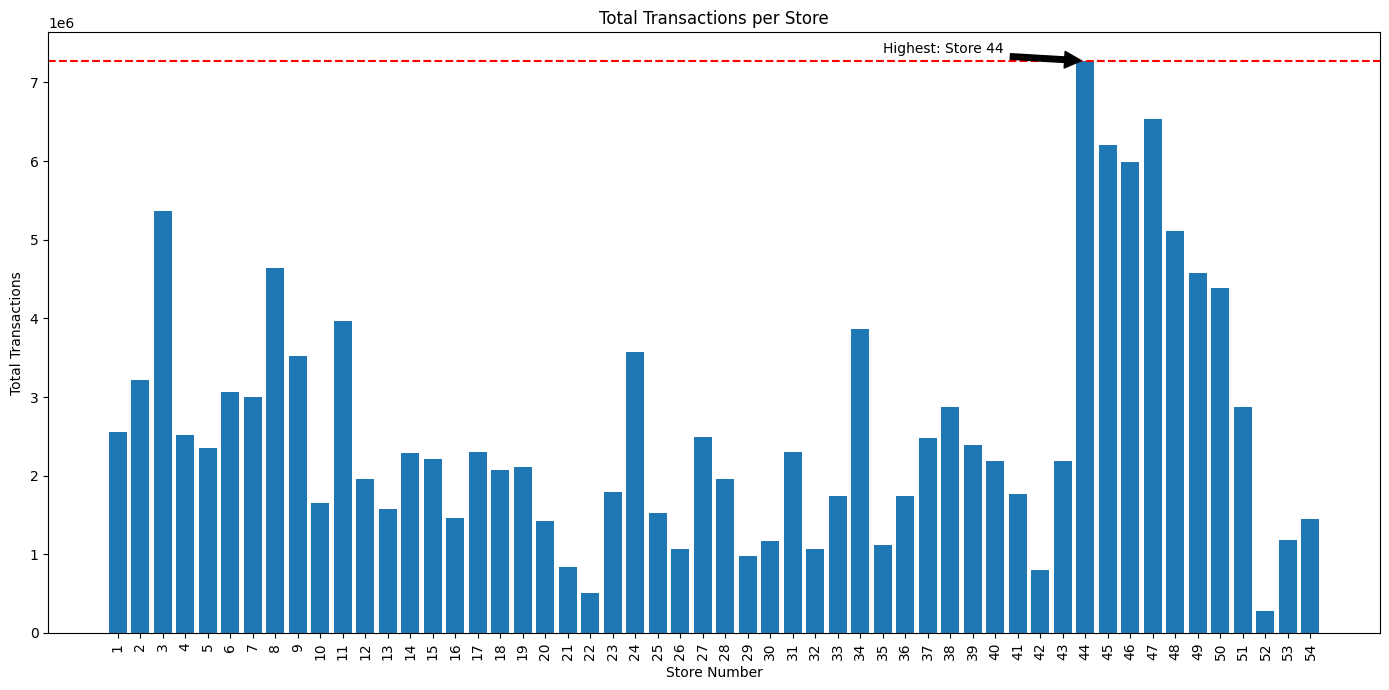

In [14]:
# Plotting
plt.figure(figsize=(14, 7))
plt.bar(total_sales_per_store['store_nbr'].astype(str), total_sales_per_store['transactions'])
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.title('Total Transactions per Store')
plt.xticks(rotation=90)  # Rotate store number labels to avoid overlap
plt.tight_layout()

# Highlight the store with the highest sales
plt.axhline(y=highest_sales_store['transactions'], color='r', linestyle='--')
plt.annotate(f'Highest: Store {highest_sales_store["store_nbr"]}', 
             xy=(highest_sales_store["store_nbr"] - 1, highest_sales_store['transactions']),
             xytext=(highest_sales_store["store_nbr"] - 10, highest_sales_store['transactions'] + 100000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.show()

In [15]:
# Merge data with items to link each sale to its item family
data_items_merged = pd.merge(data, items, on='item_nbr', how='left')

# Merge the result with stores to associate each sale with its store's location
data_items_stores_merged = pd.merge(data_items_merged, stores, on='store_nbr', how='left')

# Filter for sales in West-Bengal
west_bengal_sales = data_items_stores_merged[data_items_stores_merged['state'] == 'West Bengal']

# Aggregate sales by item family
sales_by_family = west_bengal_sales.groupby('family')['unit_sales'].sum().reset_index()

# Sort the aggregated sales to find the top-selling item family
top_selling_families = sales_by_family.sort_values(by='unit_sales', ascending=False)

# The top-selling family can be found at the top of this sorted DataFrame
top_selling_family = top_selling_families.iloc[0]

top_selling_family

family         GROCERY I
unit_sales    2933979.36
Name: 12, dtype: object

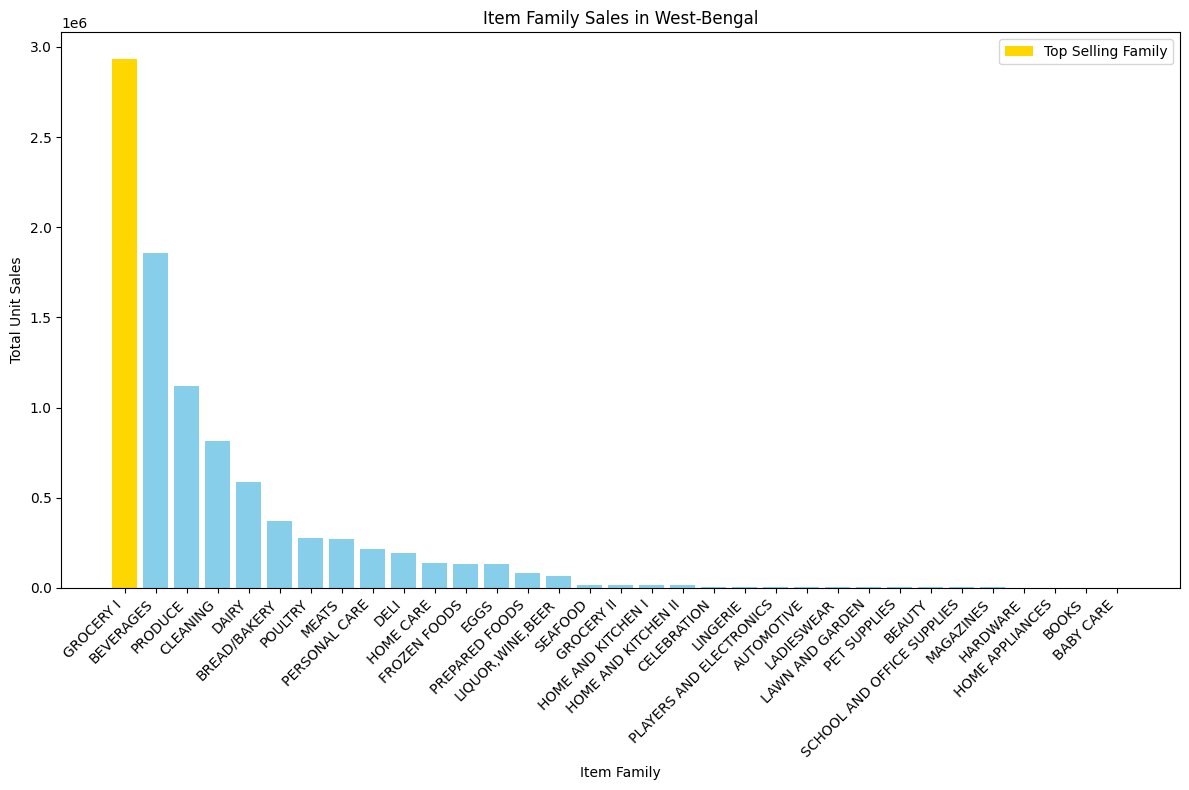

In [16]:
plt.figure(figsize=(12, 8))  # Sets the figure size
plt.bar(top_selling_families['family'], top_selling_families['unit_sales'], color='skyblue')  # Creates a bar plot
plt.title('Item Family Sales in West-Bengal')  # Title of the plot
plt.xlabel('Item Family')  # Label for the X-axis
plt.ylabel('Total Unit Sales')  # Label for the Y-axis
plt.xticks(rotation=45, ha='right')  # Rotates the X-axis labels for better readability
plt.tight_layout()  # Adjusts subplot params for the plot to fit into the figure area

# Highlighting the top-selling item family
plt.bar(top_selling_families.iloc[0]['family'], top_selling_families.iloc[0]['unit_sales'], color='gold', label='Top Selling Family')
plt.legend()  # Adds a legend to distinguish the top-selling family

plt.show()  # Displays the plot

In [ ]:
""" # 'oil' contains oil prices with 'date' and 'oil_price' columns
merged_data = pd.merge(data, oil, on='date', how='left')

daily_sales = merged_data.groupby('date')['unit_sales'].sum().reset_index()

daily_data_combined = pd.merge(daily_sales, oil, on='date', how='left')

plt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'])
plt.xlabel('Oil Price')
plt.ylabel('Total Daily Sales')
plt.title('Relationship Between Oil Price and Total Daily Sales')
plt.show()

correlation_coefficient = daily_data_combined['oil_price'].corr(daily_data_combined['unit_sales'])
print(f'Pearson correlation coefficient: {correlation_coefficient}') """

In [ ]:
""" plt.figure(figsize=(10, 6))
plt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'], alpha=0.5)
plt.title('Oil Price vs. Total Daily Sales')
plt.xlabel('Oil Price')
plt.ylabel('Total Daily Sales')
plt.grid(True)
plt.show()plt.figure(figsize=(10, 6))
plt.scatter(daily_data_combined['oil_price'], daily_data_combined['unit_sales'], alpha=0.5)
plt.title('Oil Price vs. Total Daily Sales')
plt.xlabel('Oil Price')
plt.ylabel('Total Daily Sales')
plt.grid(True)
plt.show() """

C:\Users\Cursist\AppData\Local\Temp\ipykernel_30516\1688340116.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='transactions', data=average_transactions_by_day, palette='coolwarm')


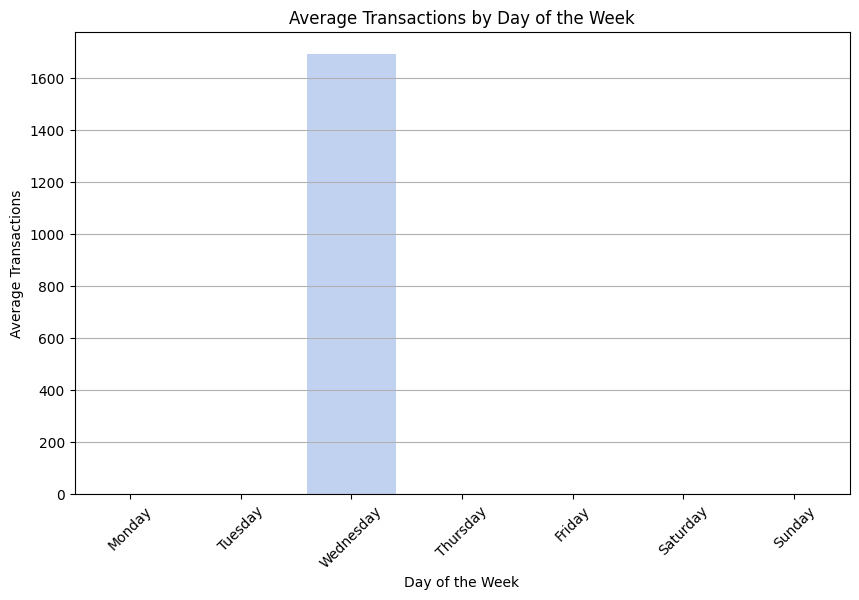

In [19]:
# Converting 'date' column to datetime format and extracting day of the week
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['day_of_week'] = transactions['date'].dt.day_name()

# Grouping the data by day of the week to calculate the average transactions
average_transactions_by_day = transactions.groupby('day_of_week')['transactions'].mean().reset_index()

# Ordering the days of the week for plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_transactions_by_day['day_of_week'] = pd.Categorical(average_transactions_by_day['day_of_week'], categories=day_order, ordered=True)
average_transactions_by_day = average_transactions_by_day.sort_values('day_of_week')

# Plotting the average transactions by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='transactions', data=average_transactions_by_day, palette='coolwarm')
plt.title('Average Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
print(holidays.head())
print(transactions.head())

# add a column 'is_holiday' to transactions: if the month_day in transactions has a occurance in holidays, set this column to true otherwise set it to false.
transactions['is_holiday'] = transactions['month_day'].isin(holidays['month_day'])

transactions_on_date = transactions[transactions['month_day'] == '01-01']
if transactions_on_date.empty:
    print("No transaction on this new year date")
else:
    print("There is a transaction on this new year date")

# ...there are no transactions on the holidays, lets check data.
""" dataRaw = pd.read_csv('dataRaw/data.csv', sep=',', low_memory=False)
data = dataRaw.copy()
data['date'] = pd.to_datetime(dataRaw['date'], format='%Y-%m-%d')
data['unit_sales'] = dataRaw['unit_sales'].round(2)
data['onpromotion'].fillna(False, inplace=True)
print(data.head()) """
# data['month_day'] = pd.to_datetime(data['date']).dt.strftime('%m-%d')
print(data.head())

data_on_date = data[data['month_day'] == '01-01']
if data_on_date.empty:
    print("No data on this new year date")
else:
    print("There is data on this new year date")

# Count unit sales on holidays
unit_sales_holidays = data[data['month_day'].isin(holidays['month_day'])]['unit_sales'].sum()

# Count unit sales on non-holidays
unit_sales_no_holidays = data[~data['month_day'].isin(holidays['month_day'])]['unit_sales'].sum()

# Plot the results in a bar chart
import matplotlib.pyplot as plt

labels = ['Holidays', 'No Holidays']
values = [unit_sales_holidays, unit_sales_no_holidays]

plt.bar(labels, values)
plt.xlabel('Date Type')
plt.ylabel('Unit Sales')
plt.title('Unit Sales on Holidays vs No Holidays')
plt.show()


In [ ]:

# Filter data for holidays
data_holidays = data[data['month_day'].isin(holidays['month_day'])]

# Filter data for no holidays
data_no_holidays = data[~data['month_day'].isin(holidays['month_day'])]

# Calculate average unit sales for holidays and no holidays
average_unit_sales_holidays = data_holidays['unit_sales'].mean()
average_unit_sales_no_holidays = data_no_holidays['unit_sales'].mean()
average_unit_sales = data['unit_sales'].mean()

# Plot the results in a bar chart
import matplotlib.pyplot as plt

labels = ['Holidays', 'No Holidays']
values = [average_unit_sales_holidays, average_unit_sales_no_holidays]

plt.bar(labels, values)
plt.xlabel('Date Type')
plt.ylabel('Average Unit Sales')
plt.title('Average Unit Sales on Holidays vs No Holidays')
plt.show()
# Filter data for holidays
data_holidays = data[data['month_day'].isin(holidays['month_day'])]

# Filter data for no holidays
data_no_holidays = data[~data['month_day'].isin(holidays['month_day'])]

# Calculate average unit sales for holidays and no holidays
average_unit_sales_holidays = data_holidays['unit_sales'].mean()
average_unit_sales_no_holidays = data_no_holidays['unit_sales'].mean()

# Compare the average unit sales
if average_unit_sales_holidays > average_unit_sales_no_holidays:
    print("Average unit sales are higher on holidays.")
elif average_unit_sales_holidays < average_unit_sales_no_holidays:
    print("Average unit sales are higher on normal days.")
else:
    print("Average unit sales are the same on holidays and no holidays.")
print("Average Unit Sales:", average_unit_sales)
print("Average Unit Sales on Holidays:", average_unit_sales_holidays)
print("Average Unit Sales on No Holidays:", average_unit_sales_no_holidays)



In [ ]:
""" # Merge the transactions with the holiday data
transactions_with_holidays = pd.merge(
    transactions,
    holidays_events,
    on='date',
    how='left'
) """

# Mark transactions that happened on holidays
transactions_with_holidays['is_holiday'] = ~transactions_with_holidays['transferred'].isnull()

# Visualize the distribution of transactions on holidays vs non-holidays using boxplots
plt.figure(figsize=(14, 7))

# First plot for all data
plt.subplot(1, 2, 1)
sns.boxplot(x='is_holiday', y='transactions', data=transactions_with_holidays)
plt.title('Transaction Distribution with Outliers')
plt.xlabel('Is Holiday')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])

# Second plot without outliers
plt.subplot(1, 2, 2)
sns.boxplot(x='is_holiday', y='transactions', data=transactions_with_holidays, showfliers=False)
plt.title('Transaction Distribution without Outliers')
plt.xlabel('Is Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])

plt.tight_layout()
plt.show()

# Calculate the average transactions on holidays vs. non-holidays
avg_trans_holiday_comparison = transactions_with_holidays.groupby('is_holiday')['transactions'].mean().reset_index()

# Print the result
print("Average transactions on non-holidays:", avg_trans_holiday_comparison.loc[avg_trans_holiday_comparison['is_holiday'] == False, 'transactions'].values[0])
print("Average transactions on holidays:", avg_trans_holiday_comparison.loc[avg_trans_holiday_comparison['is_holiday'] == True, 'transactions'].values[0])

In [ ]:
print(data.info())
# Calculate average unit sales by day of the week
average_sales_by_day = data.groupby('date').mean()['unit_sales']

# Subset of data where dates are in the holiday dataframe
holiday_sales_by_day = data[data['date'].isin(holidays_events['date'])]#.groupby('date').mean()['unit_sales']
print(holiday_sales_by_day)

# Create a bar chart
plt.bar(average_sales_by_day.index, average_sales_by_day, label='Average Unit Sales')
plt.bar(holiday_sales_by_day.index, holiday_sales_by_day, label='Holiday Unit Sales')

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Average Unit Sales')
plt.title('Average Unit Sales by Day of the Week')

# Show the legend
plt.legend()

# Display the chart
plt.show()

In [ ]:
""" # Check if the DataFrame is not empty
if not top_selling_families.empty:
    plt.figure(figsize=(12, 8))  # Sets the figure size
    plt.bar(top_selling_families['family'], top_selling_families['unit_sales'], color='skyblue')  # Creates a bar plot
    plt.title('Item Family Sales in West-Bengal')  # Title of the plot
    plt.xlabel('Item Family')  # Label for the X-axis
    plt.ylabel('Total Unit Sales')  # Label for the Y-axis
    plt.xticks(rotation=45, ha='right')  # Rotates the X-axis labels for better readability
    plt.tight_layout()  # Adjusts subplot params so the plot fits into the figure area
    
    # Highlight the top-selling item family
    plt.bar(top_selling_families.iloc[0]['family'], top_selling_families.iloc[0]['unit_sales'], color='gold', label='Top Selling Family')
    plt.legend()  # Adds a legend to distinguish the top-selling family
    
    plt.show()  # Displays the plot
else:
    print("The quest yields no data! Check if 'West-Bengal' is correctly specified or if the data contains relevant entries.") """


In [ ]:
# Quick overview of each DataFrame
for df in [data, holidays_events, items, oil, oilExtra, stores, transactions]:
    display(df.head())
    display(df.info())
    display(df.describe())

# Quick overview of each DataFrame
data_overview = {
    "DataFrame": ["data", "holidays_events", "items", "oil", "oilExtra", "stores", "transactions"],
    "First_Five_Rows": [df.head() for df in [data, holidays_events, items, oil, oilExtra, stores, transactions]],
    "Info": [df.info() for df in [data, holidays_events, items, oil, oilExtra, stores, transactions]],
    "Describe": [df.describe() for df in [data, holidays_events, items, oil, oilExtra, stores, transactions]]
}

data_overview


In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6


Aggregating Sales Data on a Weekly or Monthly Basis

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6

holidays_events['date'] = pd.to_datetime(holidays_events['date'], errors='coerce', infer_datetime_format=True)
data['is_holiday'] = data['date'].isin(holidays_events['date']).astype(int)

print(data.dtypes)

In [ ]:
# Creating a 'month_year' feature for easier aggregation by month
data['month_year'] = data['date'].dt.to_period('M')

# Aggregating sales data monthly
monthly_sales = data.groupby(['store_nbr', 'item_nbr', 'month_year'])['unit_sales'].sum().reset_index()
monthly_sales.head()

Creating Binary Variables for Holidays

In [ ]:
# Marking holidays in the main dataset
data['is_holiday'] = data['date'].isin(holidays_events['date']).astype(int)


Sales Data Aggregation

In [ ]:
# Aggregating sales data monthly, using 'year' and 'month' for grouping
monthly_sales_simplified = data.groupby(['store_nbr', 'item_nbr', 'year', 'month'])['unit_sales'].sum().reset_index()


In [ ]:
data['is_holiday'] = data['date'].isin(holidays_events['date']).astype(int)

# Now, let's proceed with the simplified monthly aggregation of sales data.
# We're grouping by 'store_nbr', 'item_nbr', 'year', and 'month', then summing up the 'unit_sales' to get monthly sales.
# This approach aggregates sales data at a monthly level without relying on the 'month_year' period column, 
# which avoids the error encountered previously.
monthly_sales_simplified = data.groupby(['store_nbr', 'item_nbr', 'year', 'month'])['unit_sales'].sum().reset_index()

# Display the head of the newly created binary variable column and the simplified monthly sales to verify our steps.
display(data[['date', 'is_holiday']].head())
monthly_sales_simplified.head()

Data Splitting

Random Forest Model Construction

In [17]:

oil_INR.rename(columns={'oil_date': 'date'}, inplace=True)  # Replace 'oil_date' as needed

# Convert 'date' columns to datetime format
data['date'] = pd.to_datetime(data['date'])
oil_INR['date'] = pd.to_datetime(oil_INR['date'])

# Merge the datasets on the 'date' column
merged_data = pd.merge(data, oil_INR, on='date', how='inner')

# Check the first few rows to ensure it merged correctly
print(merged_data.head())

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Extract the correlation of interest
oil_sales_correlation = correlation_matrix.loc['unit_sales', 'price']  # Replace 'price' as needed

print(f"The correlation coefficient between oil prices and unit sales is: {oil_sales_correlation}")

   Unnamed: 0   id       date  store_nbr  item_nbr  unit_sales  onpromotion  \
0           0    0 2013-01-01         25    103665         7.0        False   
1          60   60 2013-01-01         25    214381         5.0        False   
2         120  120 2013-01-01         25    315179         4.0        False   
3         180  180 2013-01-01         25    414752         1.0        False   
4         240  240 2013-01-01         25    557408         3.0        False   

     price change  
0  5708.32  3.29%  
1  5708.32  3.29%  
2  5708.32  3.29%  
3  5708.32  3.29%  
4  5708.32  3.29%  


ValueError: could not convert string to float: '3.29%'